In [1]:
# %pip install pyod

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
# adbench_path = "/workspace/ADBench/"
adbench_path = "/workspace/categorical-dsm/adbench_minimal/"
if adbench_path not in sys.path:
    sys.path.append(adbench_path)

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [4]:
from dataloader import get_dataset, build_tabular_ds
from torch.utils.data import DataLoader
from models.mutils import onehot_to_logit

In [5]:
from configs import census_config

config = census_config.get_config()
config.model.estimate_noise = True
config.model.ndims=2048
config.model.layers=16
config.msma.denoise=False
config.data

anomaly_label: 50000+.
categories:
- 9
- 17
- 3
- 7
- 24
- 15
- 5
- 10
- 2
- 3
- 6
- 8
- 6
- 6
- 51
- 38
- 8
- 10
- 9
- 10
- 3
- 4
- 5
- 43
- 43
- 43
- 5
- 3
dataset: census
label_column: class
numerical_features: 5

In [6]:
import runner
workdir = "workdir/census/kl_deep/"
# runner.eval(config, workdir)

In [7]:
from ood_detection_helper import ood_metrics, auxiliary_model_analysis
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [8]:
def get_msma_results(ckpt_num=-1):
    #TODO: USE PYOD MODELS!
    denoise = config.msma.denoise
    ckpt_dir = os.path.join(workdir, "checkpoints")
    ckpts = sorted(os.listdir(ckpt_dir))
    ckpt = ckpts[ckpt_num]
    step = ckpt.split("-")[0]
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["val"]["score_norms"]
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(5,6,1),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

========================= Training GMM =========================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best: 0.325495 using {'GMM__covariance_type': 'full', 'GMM__n_components': 5}
---------------------------------------------------------------------------
0.325495 (0.436729) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}


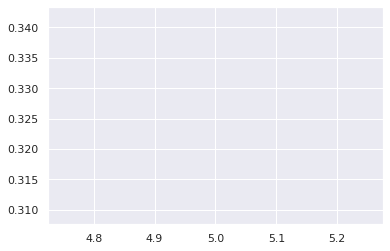

---Likelihoods---
Training: 6.977
Inlier: 6.909
Outlier: 4.013
========================= Training KD Tree =========================


dict_keys(['GMM', 'KD'])

In [8]:
msma_results = get_msma_results()
msma_results.keys()

In [10]:
msma_results["GMM"]

{'train_scores': array([ 7.49575055,  5.42485977,  3.65926147, ...,  8.34841021,
        10.20906093,  6.65576493]),
 'test_scores': array([ 8.68917056,  3.0818735 , 12.64466801, ..., 10.23384858,
         4.48699284,  3.26512033]),
 'ood_scores': array([[ 0.50340636,  4.8327023 ,  2.07654411, ...,  5.14643821,
          7.89120162, -1.61514127]]),
 'metrics':                 ap         de  fpr_tpr80  fpr_tpr95  pr_auc_in  pr_auc_out  \
 Outlier  54.927261  35.022998  49.641979  72.195504  54.921831   78.864662   
 
            roc_auc  
 Outlier  69.399022  }

In [9]:
train_loader, val_loader, test_loader = get_dataset(config, train_mode=False)

In [10]:
X_val = np.concatenate([x[0].numpy() for x in val_loader])
X_train_ = np.concatenate([x[0].numpy() for x in train_loader])
X_train = np.concatenate((X_train_, X_val))
X_train.shape

(252646, 401)

In [11]:
y_train = np.zeros(X_train.shape[0])

In [12]:
y_labels = []
X_test = []
for x,y in test_loader:
    X_test.append(x)
    y_labels.append(y)
    
X_test = np.concatenate(X_test)
y_labels = np.concatenate(y_labels)

In [13]:
X_test.shape, y_labels.shape

((46639, 401), (46639,))

In [14]:
from adbench_minimal.baseline.DAGMM.run import DAGMM as modded_DAGMM

In [15]:
modded_DAGMM

adbench_minimal.baseline.DAGMM.run.DAGMM

In [16]:
# model initialization
clf = modded_DAGMM(seed=42, model_name="dagmm", hidden_dims=[60, 30, 10], tune=False)
clf = clf.fit(X_train=X_train, y_train=y_train, ratio=0.2)
summary(clf.model.model)

number of gpu: 1
cuda name: NVIDIA RTX A6000
GPU is on
using the params: 4


/workspace/categorical-dsm/adbench_minimal/baseline/DAGMM/forward_step.py:79: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1722.)
  l = torch.cholesky(a, False)


Epoch: 0, Loss: 48578738.268
Epoch: 10, Loss: 48578727.915
Epoch: 20, Loss: 48578733.306
Epoch: 30, Loss: 48578711.497
Epoch: 40, Loss: 48578738.280
Epoch: 50, Loss: 48578741.400
Epoch: 60, Loss: 48578733.002
Epoch: 70, Loss: 48578715.761
Epoch: 80, Loss: 48578724.471
Epoch: 90, Loss: 48578731.112
Epoch: 100, Loss: 48578730.126
Epoch: 110, Loss: 48578716.819
Epoch: 120, Loss: 48578740.101
Epoch: 130, Loss: 48578735.688
Epoch: 140, Loss: 48578717.241
Epoch: 150, Loss: 48578717.327
Epoch: 160, Loss: 48578726.329
Epoch: 170, Loss: 48578734.004
Epoch: 180, Loss: 48578743.968
Epoch: 190, Loss: 48578726.763


Layer (type:depth-idx)                   Param #
DAGMM                                    --
├─Linear: 1-1                            24,120
├─Linear: 1-2                            1,830
├─Linear: 1-3                            310
├─Linear: 1-4                            11
├─Linear: 1-5                            20
├─Linear: 1-6                            330
├─Linear: 1-7                            1,860
├─Linear: 1-8                            24,461
├─Linear: 1-9                            40
├─Linear: 1-10                           44
Total params: 53,026
Trainable params: 53,026
Non-trainable params: 0

Testing...
----------------
ROC-AUC: 48.3372
PR-AUC (In/Out): 38.6471 / 58.9184
FPR (95% TPR): 95.83%
Detection Error: 49.56%


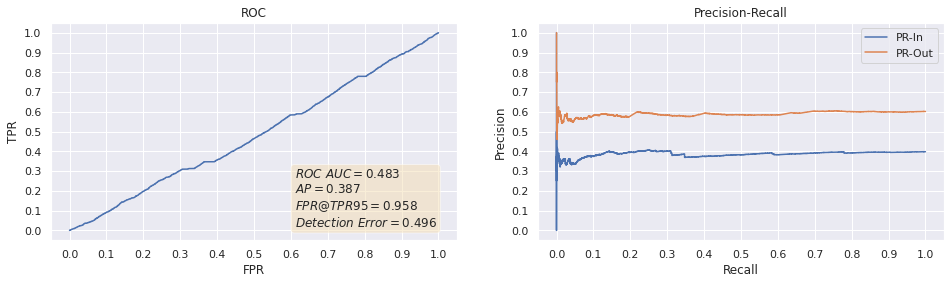

In [17]:
score = clf.predict_score(X_train, X_test[1::2])

results = ood_metrics(score[y_labels[1::2]==0], score[y_labels[1::2]==1], plot=True, verbose=True)

In [ ]:
# model initialization
clf = modded_DAGMM(seed=42, model_name="dagmm", hidden_dims=[128, 64, 32], latent_dim=4, lr=3e-4, tune=False)
clf = clf.fit(X_train=X_train, y_train=y_train, ratio=0.2)
summary(clf.model.model)

number of gpu: 1
cuda name: NVIDIA RTX A6000
GPU is on
using the params: 4
Epoch: 0, Loss: 40697198.970
Epoch: 10, Loss: 40697200.252
Epoch: 20, Loss: 40697194.428
Epoch: 30, Loss: 40697203.136
Epoch: 40, Loss: 40697203.584
Epoch: 50, Loss: 40697208.915
Epoch: 60, Loss: 40697190.576
Epoch: 70, Loss: 40697189.550


In [19]:
# summary(clf.model.model)

In [ ]:
score = clf.predict_score(X_train, X_test[1::2])
results = ood_metrics(score[y_labels[1::2]==0], score[y_labels[1::2]==1], plot=True, verbose=True)

In [25]:
# train an ECOD detector
from pyod.models.ecod import ECOD
clf = ECOD()
clf.fit(X_train)

# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test


In [31]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)

In [26]:
y_test_scores[:10]

array([32.39758328, 51.28013137, 36.69141262, 48.15539863, 83.98769243,
       60.14595204, 32.54692095, 77.18953911, 49.15872515, 55.05823813])

----------------
ROC-AUC: 46.7260
PR-AUC (In/Out): 36.2938 / 60.3436
FPR (95% TPR): 93.97%
Detection Error: 47.35%


{'fpr_tpr95': 0.9396530226924584,
 'de': 0.47345163425155495,
 'roc_auc': 0.46726016215483385,
 'pr_auc_in': 0.3629376630198865,
 'pr_auc_out': 0.6034358145072192,
 'fpr_tpr80': 0.7413344732998468,
 'ap': 0.3629945811414923}

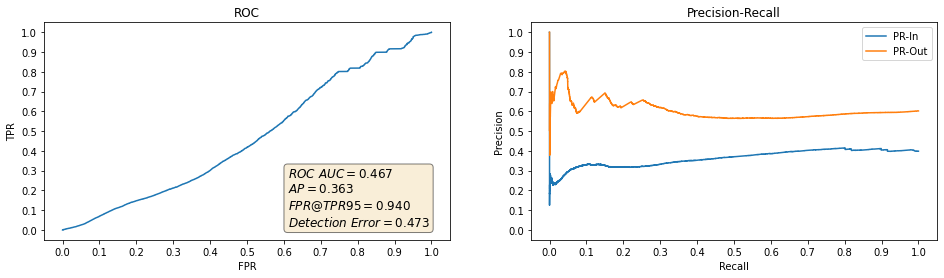

In [28]:
ood_metrics(y_test_scores[y_labels==0], y_test_scores[y_labels==1], plot=True, verbose=True)

In [66]:
ood_scores.shape[0]

18568

In [67]:
id_scores = msma_results["GMM"]["test_scores"]
ood_scores = msma_results["GMM"]["ood_scores"].squeeze()

msma_labels=np.concatenate((np.zeros(id_scores.shape[0]), np.ones(ood_scores.shape[0])))
msma_scores=-np.concatenate((id_scores, ood_scores))

In [68]:
evaluate_print("MSMA", msma_labels, msma_scores)

MSMA ROC:0.6937, precision @ rank n:0.5497


In [70]:
evaluate_print("ECOD", y_labels, y_test_scores)

# visualize the results
# visualize("ECOD", X_train[:, 1:5:2], y_train, X_test[:, 1:5:2], y_labels, y_train_pred,
#               y_test_pred, show_figure=True, save_figure=False)

ECOD ROC:0.4673, precision @ rank n:0.3446


### AD Bench Test

In [138]:
# %pip install barbar

In [143]:
from baseline.PyOD import PYOD
from baseline.DAGMM.run import DAGMM
from myutils import Utils
utils = Utils() 

dataset_list = ["Census"]
model_dict = {'IForest': PYOD, 'ECOD': PYOD, 'DeepSVDD': PYOD, 'DAGMM':DAGMM}
model_list = list(model_dict.keys())

# save the results
df_metrics = pd.DataFrame(data=None, index=["MSMA-GMM"]+model_list, columns = msma_results["GMM"]["metrics"].columns)
df_metrics.loc["MSMA-GMM", :] = msma_results["GMM"]["metrics"].squeeze()
df_metrics

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
MSMA-GMM,54.886684,34.966113,49.599231,72.241815,54.881348,78.858775,69.368872
IForest,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeepSVDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAGMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
PYOD()

In [115]:
y_labels.sum()/(y_train.shape[0]+y_labels.shape[0])

0.24853100614367363

Running: IForest
-----------------------
The candidate hyper-parameter of IForest: [10, 50, 100, 500],  corresponding metric: [0.1648374987471663, 0.16236770042958654, 0.15313182152713184, 0.15471421601415009]  the best candidate: 10
best param: 10
----------------
ROC-AUC: 45.4066
PR-AUC (In/Out): 38.2483 / 55.0272
FPR (95% TPR): 86.51%
Detection Error: 49.62%
Running: DeepSVDD
-----------------------
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 401)]             0         
                                                                 
 dense_5 (Dense)             (None, 64)                25664     
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 32)         

/home/amahmood/.local/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


----------------
ROC-AUC: 37.9839
PR-AUC (In/Out): 32.7487 / 51.7503
FPR (95% TPR): 98.40%
Detection Error: 49.99%


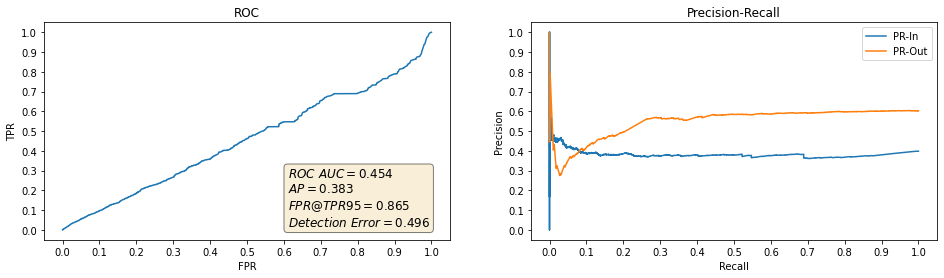

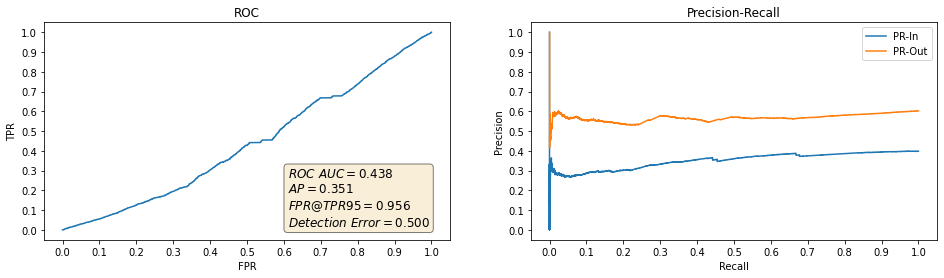

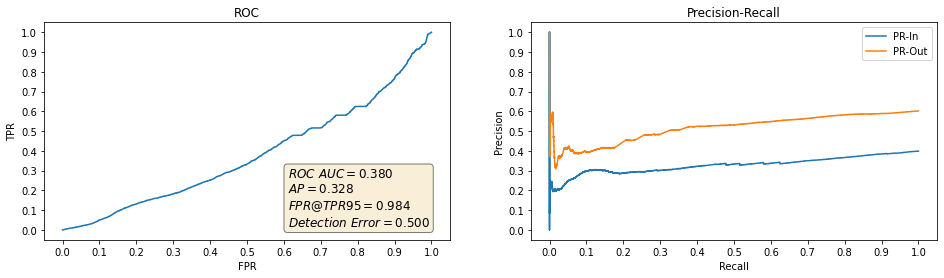

In [119]:
# seed for reproducible results
seed = 42
name, clf = 'IForest', PYOD
model_scores = {}

for name, clf in model_dict.items():
        print(f"Running: {name}")
        print("-----------------------")
        
        # model initialization
        clf = clf(seed=seed, model_name=name, tune=True)
        
        # training, for unsupervised models the y label will be discarded
        clf = clf.fit(X_train=X_test[::2], y_train=y_labels[::2], ratio=0.2)
        
        # output predicted anomaly score on testing set
        score = clf.predict_score(X_test[1::2])

        # evaluation
        results = ood_metrics(score[y_labels[1::2]==0], score[y_labels[1::2]==1], plot=True, verbose=True)
        
        # save results
        
        model_scores[name] = score
        df_metrics.loc[name, :] = results
        df_metrics.loc[name, :] *= 100

In [145]:
# seed for reproducible results
seed = 42
name, clf = 'DAGMM', DAGMM

print(f"Running: {name}")
print("-----------------------")

# model initialization
clf = clf(seed=seed, model_name=name, tune=False)

# training, for unsupervised models the y label will be discarded
clf = clf.fit(X_train=X_val, y_train=y_train[:len(X_val)], ratio=0.2)

Running: DAGMM
-----------------------
using the params: 4


In [156]:
# DAGMM, modded_DAGMM

In [150]:
summary(clf.model.model)

Layer (type:depth-idx)                   Param #
DAGMM                                    --
├─Linear: 1-1                            24,120
├─Linear: 1-2                            1,830
├─Linear: 1-3                            310
├─Linear: 1-4                            11
├─Linear: 1-5                            20
├─Linear: 1-6                            330
├─Linear: 1-7                            1,860
├─Linear: 1-8                            24,461
├─Linear: 1-9                            40
├─Linear: 1-10                           44
Total params: 53,026
Trainable params: 53,026
Non-trainable params: 0

Testing...
----------------
ROC-AUC: 46.9606
PR-AUC (In/Out): 37.3567 / 57.9481
FPR (95% TPR): 96.03%
Detection Error: 49.96%


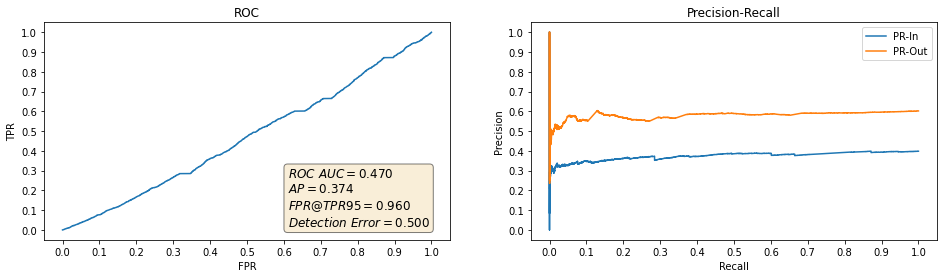

In [146]:
# output predicted anomaly score on testing set
score = clf.predict_score(X_train, X_test[1::2])

# evaluation
results = ood_metrics(score[y_labels[1::2]==0], score[y_labels[1::2]==1], plot=True, verbose=True)

# save results

model_scores[name] = score
df_metrics.loc[name, :] = results
df_metrics.loc[name, :] *= 100

<AxesSubplot:>

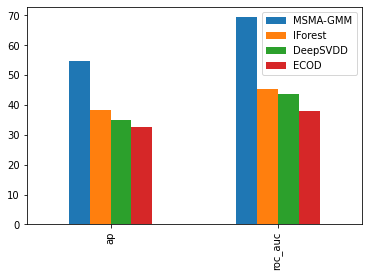

In [134]:
df_metrics[["ap","roc_auc"]].T.plot(kind="bar")

<AxesSubplot:>

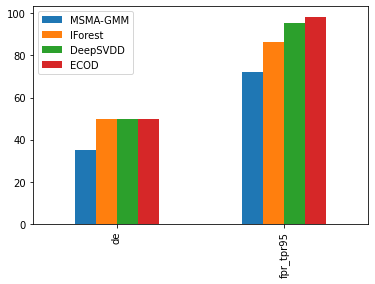

In [133]:
df_metrics[["de","fpr_tpr95"]].T.plot(kind="bar")

### Training PyOD on score norms

In [125]:
#TODO: USE PYOD MODELS!
ckpt_num = -1
denoise = config.msma.denoise
ckpt_dir = os.path.join(workdir, "checkpoints")
ckpts = sorted(os.listdir(ckpt_dir))
ckpt = ckpts[ckpt_num]
step = ckpt.split("-")[0]
fname = os.path.join(
        workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
    )
with np.load(fname, allow_pickle=True) as npzfile:
    outdict = {k: npzfile[k].item() for k in npzfile.files}


score_norm_train = outdict["val"]["score_norms"]
test_labels = outdict["test"]["labels"][::2]
score_norm_test = outdict["test"]["score_norms"][::2]

In [127]:
score_norm_train.shape, score_norm_test.shape, test_labels.shape, 

((28072, 10), (23320, 10), (23320,))

In [129]:
from pyod.models.knn import KNN

----------------
ROC-AUC: 70.2278
PR-AUC (In/Out): 55.4991 / 79.5256
FPR (95% TPR): 71.77%
Detection Error: 34.69%


{'fpr_tpr95': 0.7177258478198917,
 'de': 0.34690619517314314,
 'roc_auc': 0.7022784413293618,
 'pr_auc_in': 0.5549912544099016,
 'pr_auc_out': 0.7952559431905647,
 'fpr_tpr80': 0.48624964377315477,
 'ap': 0.55509598736233}

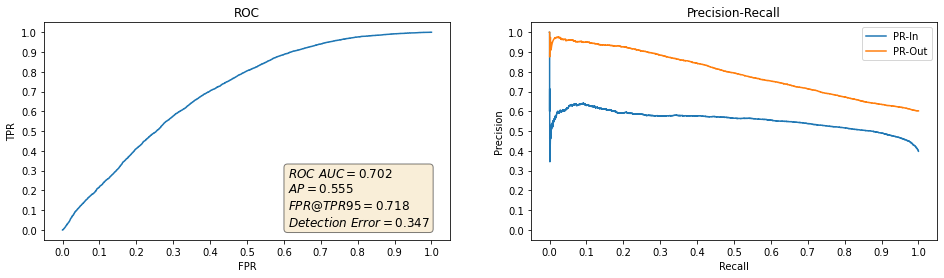

In [130]:
clf = KNN()
clf.fit(score_norm_train)

# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
y_test_scores = clf.decision_function(score_norm_test)  # predict raw outlier scores on test
ood_metrics(y_test_scores[test_labels==0], y_test_scores[test_labels==1], plot=True, verbose=True)